In [2]:
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

# Load datasets
crime = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/crime_dataset.csv", parse_dates=['date'])
weather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Chicago_weather_cleaned.csv", parse_dates=['datetime'])

# Ensure consistent date columns
crime['date'] = crime['date'].dt.date
weather['date'] = weather['datetime'].dt.date

# Aggregate daily crime counts
daily_crime = crime.groupby('date').size().reset_index(name='crime_count')

# Merge on date
merged = pd.merge(daily_crime, weather, on='date', how='inner')

print("Merged shape:", merged.shape)
merged.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Merged shape: (974, 35)


,date,crime_count,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,...,uvindex,severerisk,sunrise,sunset,moonphase,conditions,month,year,dayofweek,is_weekend
0,2023-01-01,979,2023-01-01,44.7,37.1,41.5,41.1,31.8,38.3,38.6,...,2,10.0,2023-01-01T07:18:26,2023-01-01T16:30:24,0.32,"Rain, Overcast",1,2023,6,True
1,2023-01-02,640,2023-01-02,43.7,32.0,38.4,40.3,31.1,35.0,35.8,...,2,10.0,2023-01-02T07:18:30,2023-01-02T16:31:16,0.36,Partially cloudy,1,2023,0,False
2,2023-01-03,724,2023-01-03,47.6,39.7,43.5,45.6,32.9,40.2,42.4,...,1,10.0,2023-01-03T07:18:33,2023-01-03T16:32:10,0.39,"Rain, Overcast",1,2023,1,False
3,2023-01-04,668,2023-01-04,45.8,33.3,37.0,41.7,25.1,30.6,32.3,...,1,10.0,2023-01-04T07:18:33,2023-01-04T16:33:05,0.42,"Snow, Rain, Partially cloudy",1,2023,2,False
4,2023-01-05,644,2023-01-05,34.1,32.0,32.9,28.1,22.1,25.0,28.0,...,1,10.0,2023-01-05T07:18:30,2023-01-05T16:34:02,0.46,"Snow, Rain, Overcast",1,2023,3,False


In [3]:
weather_features = [
    'tempmax', 'tempmin', 'temp', 'humidity', 'precip',
    'windspeed', 'visibility', 'cloudcover', 'solarradiation'
]

data = merged[['date', 'crime_count'] + weather_features].copy()
data.describe()

,crime_count,tempmax,tempmin,temp,humidity,precip,windspeed,visibility,cloudcover,solarradiation
count,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000,974.000000
mean,682.364476,62.883470,47.710472,55.147433,62.871561,0.090152,16.269918,9.282546,66.531314,150.146099
std,77.378301,20.020811,18.172691,18.781258,12.527275,0.264847,4.712064,1.293467,26.188608,89.468705
min,110.000000,1.900000,-9.200000,-5.700000,30.900000,0.000000,5.700000,1.100000,0.000000,5.100000
25%,640.000000,46.800000,34.100000,40.225000,54.125000,0.000000,12.700000,9.300000,46.700000,76.000000
50%,684.500000,65.900000,48.500000,57.050000,61.900000,0.000000,15.700000,9.900000,70.200000,139.250000
75%,731.750000,80.000000,63.900000,71.600000,72.275000,0.034000,18.900000,9.900000,89.775000,225.700000
max,979.000000,100.000000,80.000000,89.600000,96.000000,3.560000,36.400000,9.900000,100.000000,365.400000


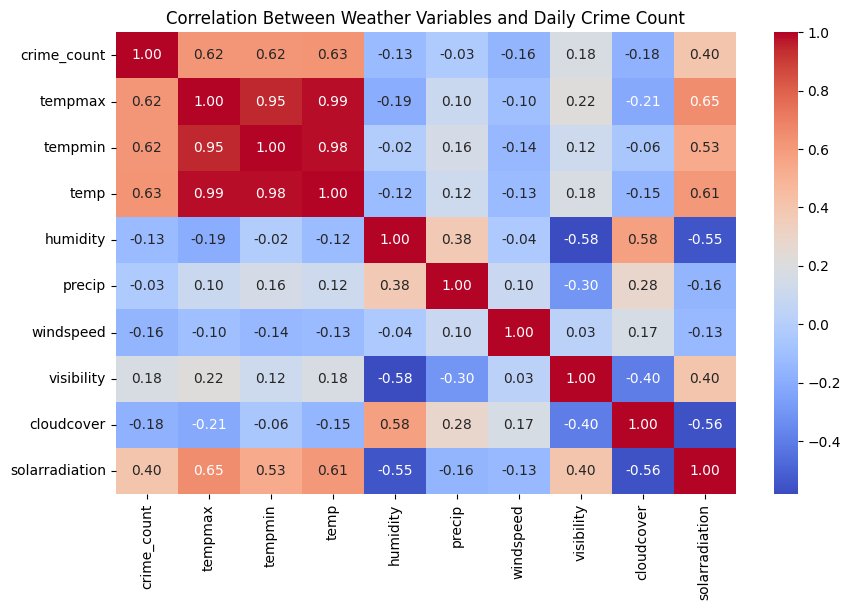

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = data.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between Weather Variables and Daily Crime Count")
plt.show()

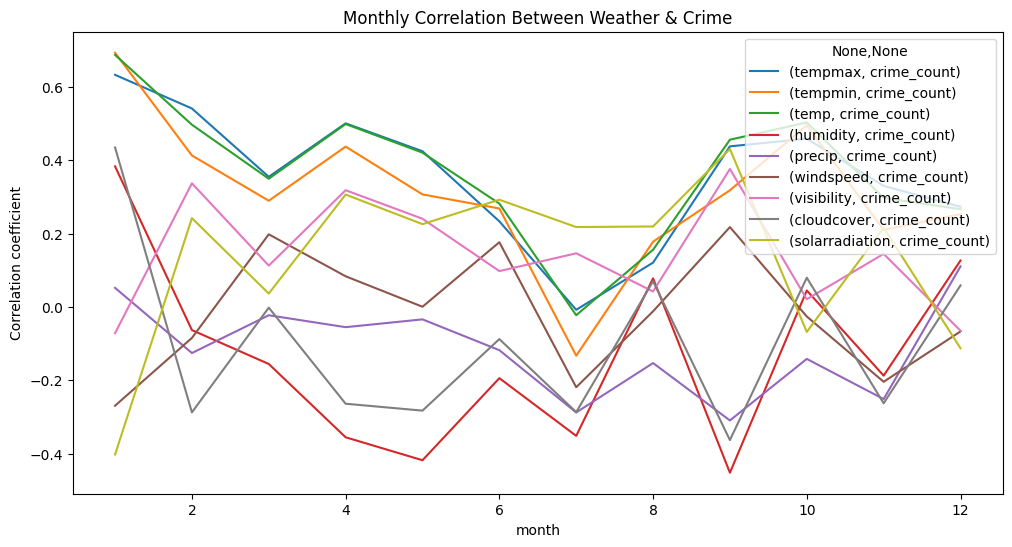

In [5]:
data['month'] = pd.to_datetime(data['date']).dt.month
seasonal_corr = data.groupby('month')[['crime_count'] + weather_features].corr().loc[(slice(None), 'crime_count'), weather_features]
seasonal_corr.unstack().plot(figsize=(12,6), title="Monthly Correlation Between Weather & Crime")
plt.ylabel("Correlation coefficient")
plt.show()

In [6]:
import numpy as np

data['is_hot_day'] = np.where(data['tempmax'] > 85, 1, 0)
data['is_rainy_day'] = np.where(data['precip'] > 0.1, 1, 0)

summary = data.groupby(['is_hot_day','is_rainy_day'])['crime_count'].mean().unstack()
summary

is_rainy_day,0,1
is_hot_day,,
0,674.747110,668.756410
1,744.970874,723.478261


<Axes: xlabel='tempmax_lag1', ylabel='crime_count'>

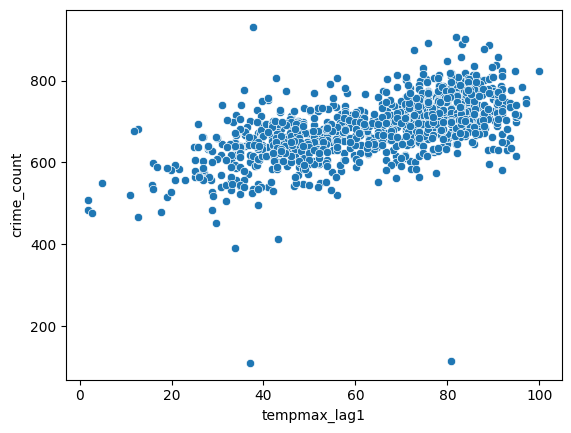

In [7]:
data['tempmax_lag1'] = data['tempmax'].shift(1)
sns.scatterplot(x='tempmax_lag1', y='crime_count', data=data)

/tmp/ipython-input-1796658067.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[weather_features].fillna(method='ffill')


<Axes: title={'center': 'Weather Feature Importance for Crime Prediction'}>

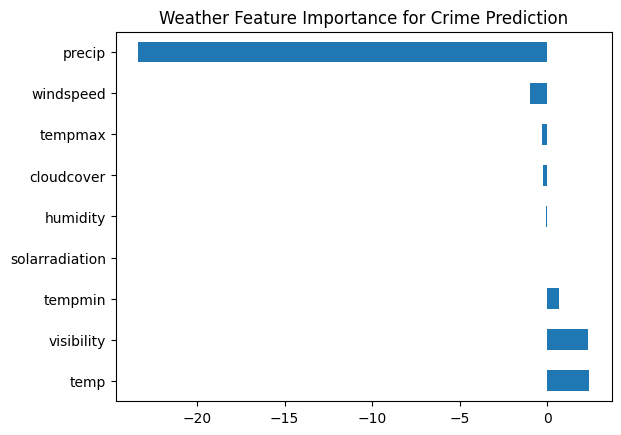

In [8]:
from sklearn.linear_model import LinearRegression

X = data[weather_features].fillna(method='ffill')
y = data['crime_count']

model = LinearRegression()
model.fit(X, y)

importance = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)
importance.plot(kind='barh', title="Weather Feature Importance for Crime Prediction")

In [10]:
merged.to_csv("/content/drive/MyDrive/Colab Notebooks/crime_weather_merged.csv", index=False)

Weather vs Crime — EDA

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Load datasets ===
crime = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/crime_dataset.csv",
                    parse_dates=['date'])
weather = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Chicago_weather_cleaned.csv",
                      parse_dates=['datetime'])


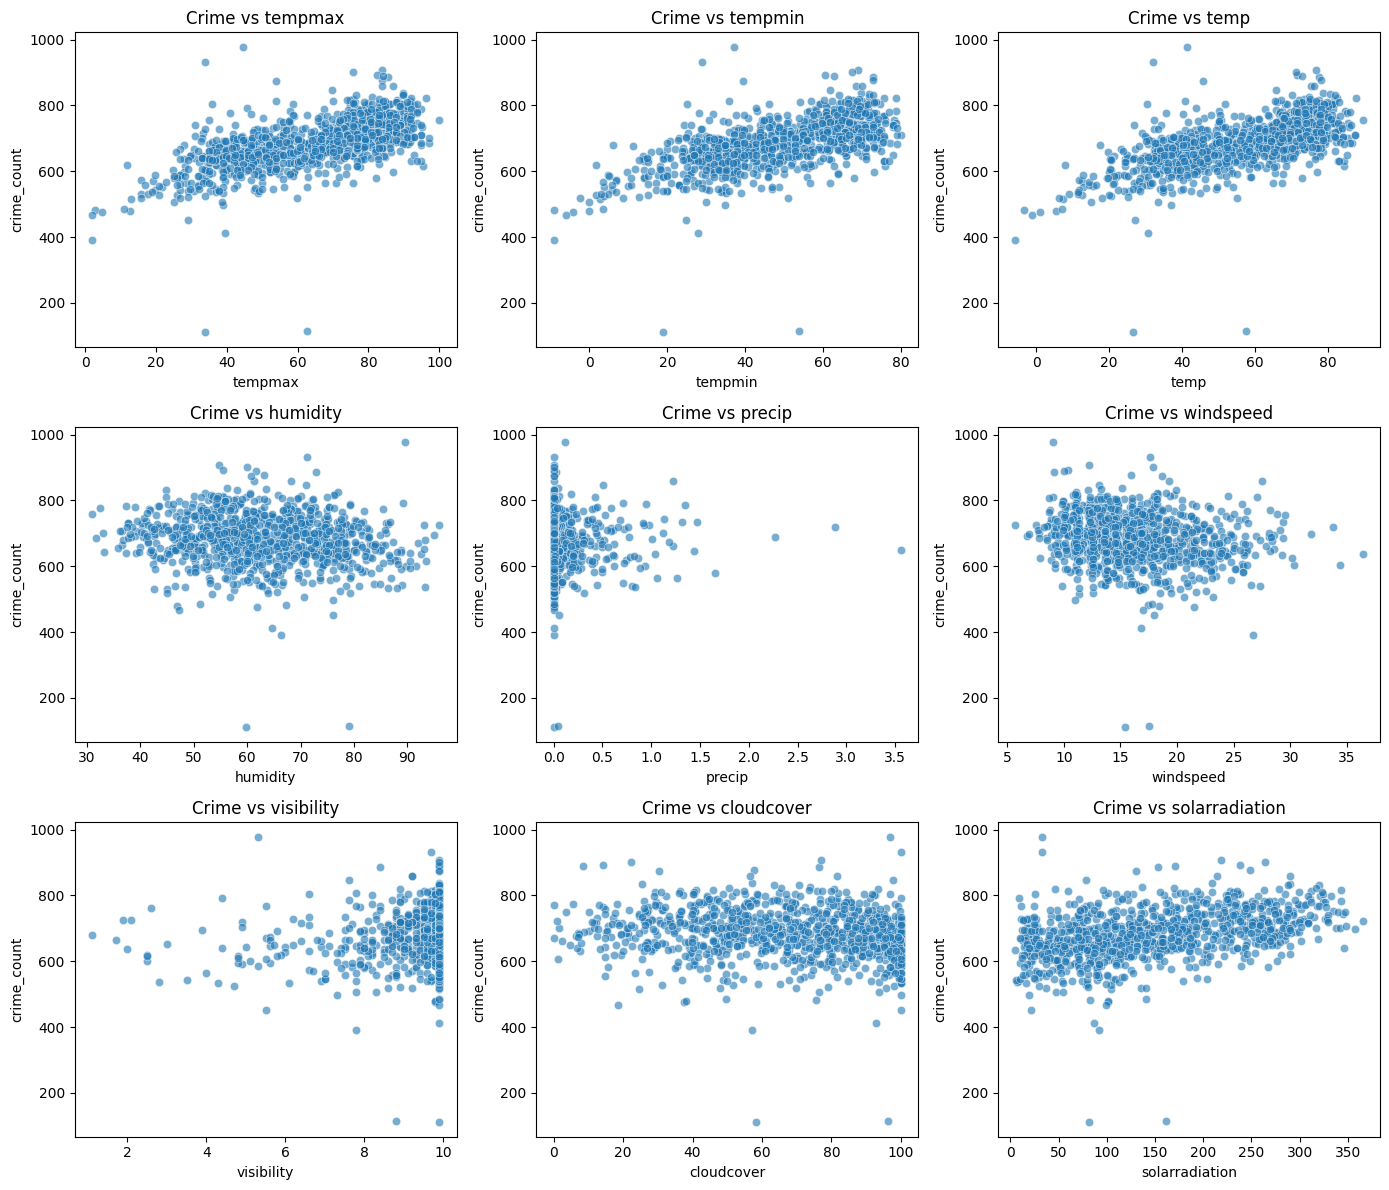

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(14,12))
axes = axes.flatten()

for i, col in enumerate(weather_features):
    sns.scatterplot(x=col, y='crime_count', data=data, ax=axes[i], alpha=0.6)
    axes[i].set_title(f"Crime vs {col}")

plt.tight_layout()
plt.show()

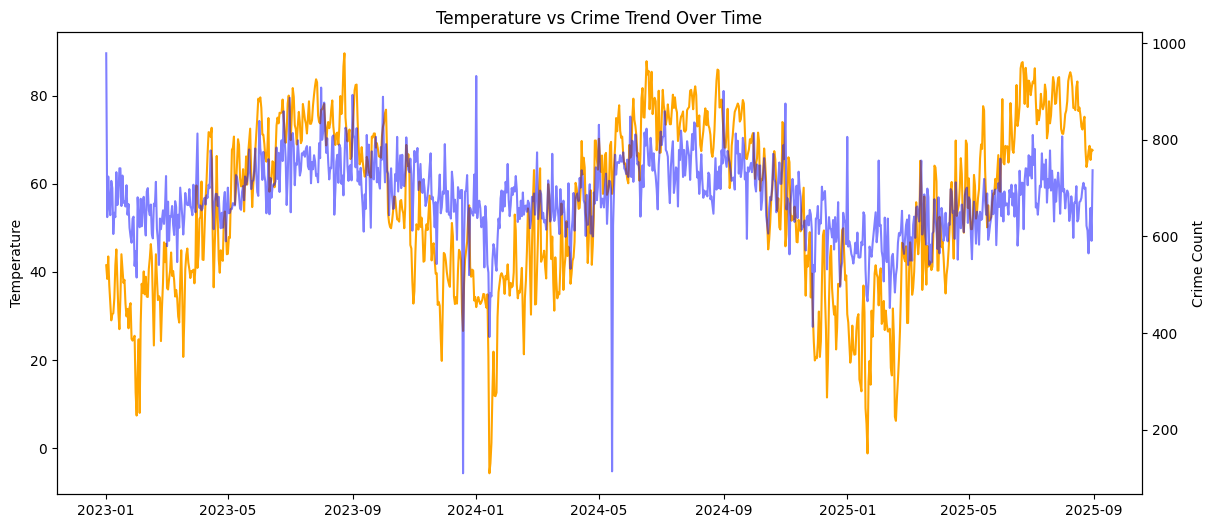

In [17]:
plt.figure(figsize=(14,6))
plt.plot(data['date'], data['temp'], label='Average Temp (°F)', color='orange')
plt.ylabel("Temperature")
plt.twinx()
plt.plot(data['date'], data['crime_count'], label='Crime Count', color='blue', alpha=0.5)
plt.ylabel("Crime Count")
plt.title("Temperature vs Crime Trend Over Time")
plt.show()

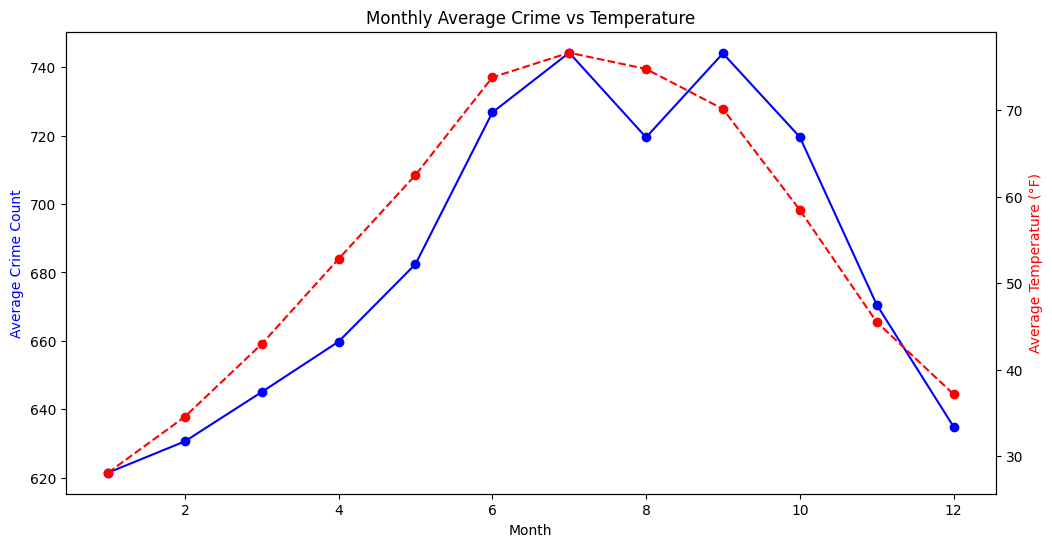

In [18]:
data['month'] = pd.to_datetime(data['date']).dt.month

monthly = data.groupby('month')[['crime_count','temp','humidity','precip']].mean()

fig, ax1 = plt.subplots(figsize=(12,6))
ax2 = ax1.twinx()

ax1.plot(monthly.index, monthly['crime_count'], 'b-o', label='Crime Count')
ax2.plot(monthly.index, monthly['temp'], 'r--o', label='Temp (°F)')

ax1.set_xlabel("Month")
ax1.set_ylabel("Average Crime Count", color='b')
ax2.set_ylabel("Average Temperature (°F)", color='r')
plt.title("Monthly Average Crime vs Temperature")
plt.show()

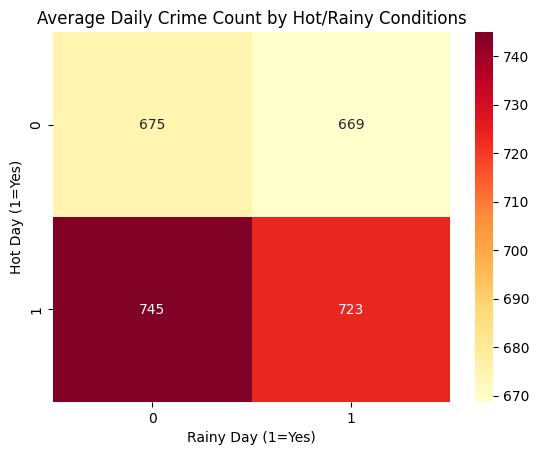

In [19]:
data['is_hot_day'] = np.where(data['tempmax'] > 85, 1, 0)
data['is_rainy_day'] = np.where(data['precip'] > 0.1, 1, 0)

summary = data.groupby(['is_hot_day', 'is_rainy_day'])['crime_count'].mean().unstack()

sns.heatmap(summary, annot=True, fmt=".0f", cmap="YlOrRd")
plt.title("Average Daily Crime Count by Hot/Rainy Conditions")
plt.xlabel("Rainy Day (1=Yes)")
plt.ylabel("Hot Day (1=Yes)")
plt.show()

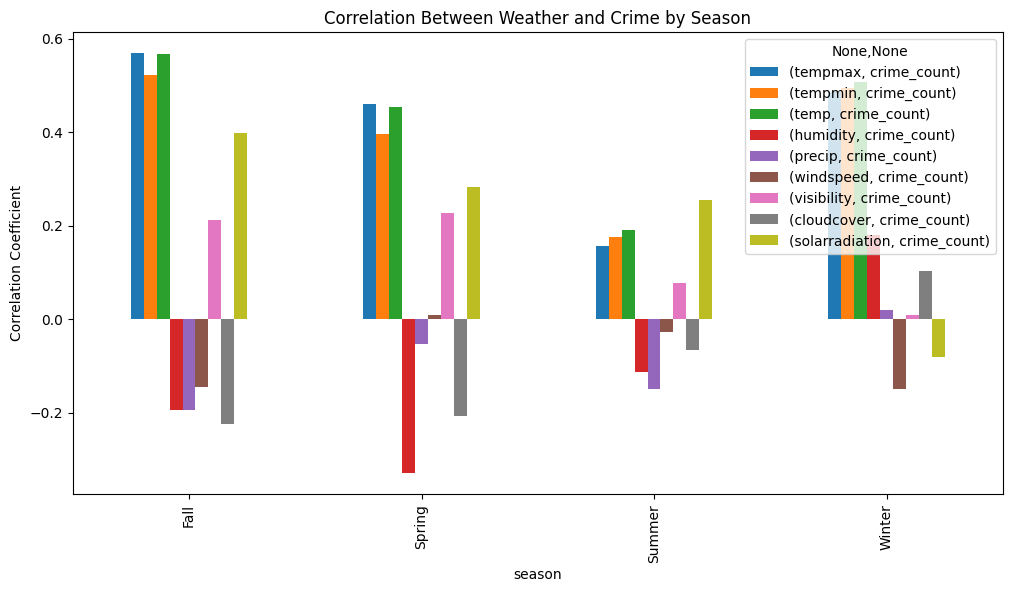

In [20]:
data['season'] = pd.to_datetime(data['date']).dt.month%12 // 3 + 1
season_labels = {1:'Winter',2:'Spring',3:'Summer',4:'Fall'}
data['season'] = data['season'].map(season_labels)

season_corr = data.groupby('season')[['crime_count'] + weather_features].corr().loc[(slice(None),'crime_count'), weather_features]
season_corr.unstack().plot(kind='bar', figsize=(12,6))
plt.title("Correlation Between Weather and Crime by Season")
plt.ylabel("Correlation Coefficient")
plt.show()

/tmp/ipython-input-3295333652.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = data[weather_features].fillna(method='ffill')


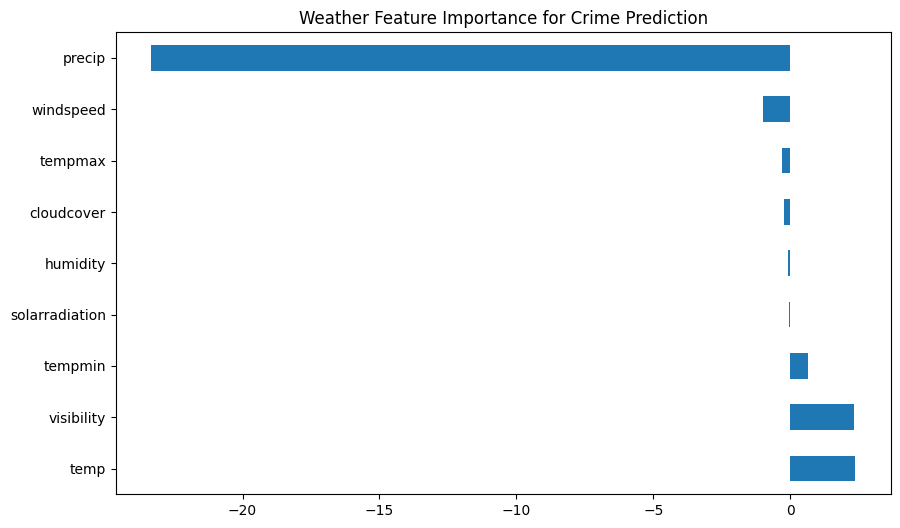

In [21]:
from sklearn.linear_model import LinearRegression

X = data[weather_features].fillna(method='ffill')
y = data['crime_count']

model = LinearRegression().fit(X, y)
importance = pd.Series(model.coef_, index=X.columns).sort_values(ascending=False)

importance.plot(kind='barh', title="Weather Feature Importance for Crime Prediction", figsize=(10,6))
plt.show()

In [22]:
insights = {
    "temp": "Crime tends to rise on warmer days.",
    "precip": "Rain correlates with fewer crimes (indoor shift).",
    "humidity": "Higher humidity slightly reduces crime.",
    "windspeed": "Windy conditions reduce outdoor crimes.",
    "visibility": "Poor visibility deters some crime types."
}

pd.DataFrame.from_dict(insights, orient='index', columns=['Observed Relationship'])

,Observed Relationship
temp,Crime tends to rise on warmer days.
precip,Rain correlates with fewer crimes (indoor shift).
humidity,Higher humidity slightly reduces crime.
windspeed,Windy conditions reduce outdoor crimes.
visibility,Poor visibility deters some crime types.
